# 15.077: Problem Set 4
Alex Berke (aberke)

From

Hastie, T., Tibshirani, R., and Friedman, J., The Elements of Statistical Learning: Data Mining, Inference and Prediction, Springer, 2nd ed., 2009 (ISBN 978-0-387-84857-0). https://web.stanford.edu/~hastie/ElemStatLearn/

In [1]:
%config Completer.use_jedi = False # autocomplete

import numpy as np
import pandas as pd
import scipy.special
from scipy import stats


import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Problems

## 1. 2.8
### Compare the classification performance of linear regression and k– nearest neighbor classification on the zipcode data. In particular, consider only the 2’s and 3’s, and k = 1, 3, 5, 7 and 15. Show both the training and test error for each choice.


When we  consider  only the  2's and 3's this becomes   a binary classification problem.

In that case, we can limit the data to where y in {2,3} and encode the data as 2 = 0, 3 = 1.

##### About the data:

(http://www-stat.stanford.edu/ElemStatLearn)

Normalized handwritten digits, automatically scanned from envelopes by the U.S. Postal Service. The original  scanned digits are binary and of different sizes and orientations; the
images  here have been deslanted and size normalized, resulting in 16 x 16 grayscale images (Le Cun et al., 1990).

The data are in two gzipped files, and each line consists of the digit
id (0-9) followed by the 256 grayscale values.


The test set is notoriously "difficult", and a 2.5% error rate is
excellent.

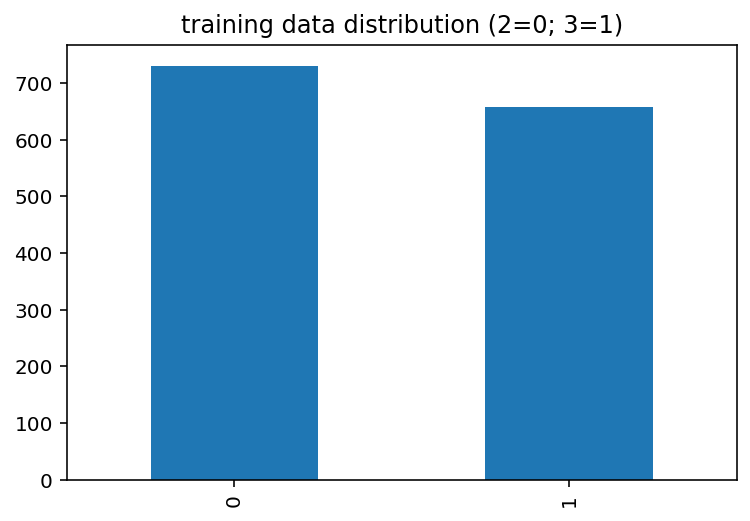

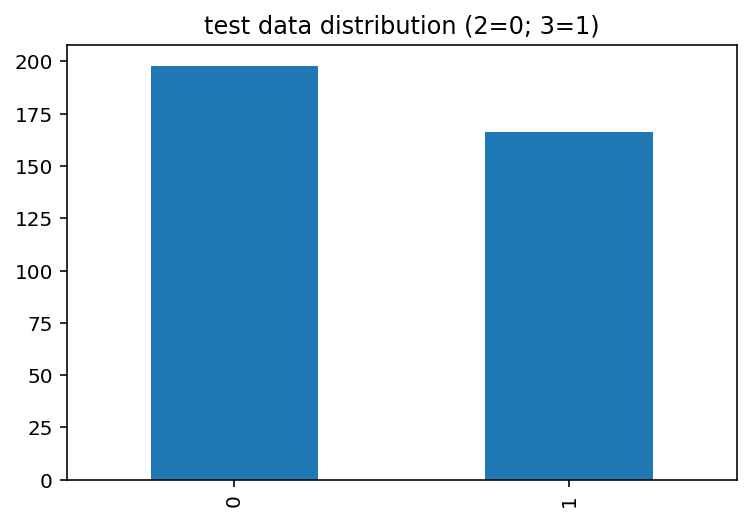

,y,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
4,1,-1.0,-1.0,-1.0,-1.00,-1.000,-0.928,-0.204,0.751,0.466,...,0.466,0.639,1.000,1.000,0.791,0.439,-0.199,-0.883,-1.0,-1.0
6,1,-1.0,-1.0,-1.0,-0.83,0.442,1.000,1.000,0.479,-0.328,...,1.000,0.671,0.345,-0.507,-1.000,-1.000,-1.000,-1.000,-1.0,-1.0
26,1,-1.0,-1.0,-1.0,-1.00,-1.000,-0.104,0.549,0.579,0.579,...,0.388,0.579,0.811,1.000,1.000,0.715,0.107,-0.526,-1.0,-1.0
30,1,-1.0,-1.0,-1.0,-1.00,-1.000,-1.000,-0.107,1.000,1.000,...,-0.280,0.322,0.813,1.000,1.000,0.633,-0.144,-0.994,-1.0,-1.0
35,1,-1.0,-1.0,-1.0,-1.00,-0.674,0.492,0.573,0.755,-0.018,...,0.537,1.000,1.000,0.689,-0.530,-1.000,-1.000,-1.000,-1.0,-1.0


In [118]:
zips_train = pd.read_csv('zip.train.gz', compression='gzip', header=None, delimiter=" ").rename(columns={0:'y'}).drop(257, axis=1)
zips_test = pd.read_csv('zip.test.gz', compression='gzip', header=None, delimiter=" ").rename(columns={0:'y'})

# limit the data to 2's and 3's and recode the data as 2 = 0, 3 = 1.
zips_train = zips_train[zips_train['y'].isin([2,3])]
zips_test = zips_test[zips_test['y'].isin([2,3])]

zips_train['y'] =  zips_train['y'].map(lambda y: 0 if y==2 else 1)
zips_test['y'] =  zips_test['y'].map(lambda y: 0 if y==2 else 1)

# plot the data
zips_train['y'].value_counts().plot.bar()
plt.title('training data distribution (2=0; 3=1)')
plt.show()
zips_test['y'].value_counts().plot.bar()
plt.title('test data distribution (2=0; 3=1)')
plt.show()

zips_train.head()

Make  error  table

columns:
```
model, train, test
```

models:
- linear
- k=1
- k=3
- k=5
- k=7
- k=15

In [119]:
errors_df = pd.DataFrame(columns=['model', 'train', 'test']).set_index('model')

In [120]:
train_X = zips_train[list(range(1,256+1))]
test_X = zips_test[list(range(1,256+1))]

train_y = zips_train['y']
test_y = zips_test['y']

In [121]:
def transform_predicted(predicted):
    """Map to 0 if  y < 0.5; 1 otherwise"""
    return [(0  if y < 0.5 else  1) for y in predicted]

def get_error_rate(predicted, true):
    return np.abs(predicted - true).sum()/len(true)
    

In [122]:
# linear regression model
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression().fit(train_X, train_y)
assert(256==len(model_lr.coef_))
assert(np.abs(model_lr.intercept_)>0)

train_predicted = model_lr.predict(train_X)
test_predicted = model_lr.predict(test_X)

train_error_lr = get_error_rate(transform_predicted(train_predicted), train_y)
test_error_lr = get_error_rate(transform_predicted(test_predicted), test_y)

errors_df.loc['linear','train'] = train_error_lr
errors_df.loc['linear','test'] = test_error_lr

In [123]:
# K-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

for k in [1,3,5,7,15]:
    model_kn = KNeighborsClassifier(n_neighbors=k)
    model_kn.fit(train_X, train_y)
    train_error_kn = get_error_rate(model_kn.predict(train_X), train_y)
    test_error_kn = get_error_rate(model_kn.predict(test_X), test_y)
    errors_df.loc['k = %s' % k, 'train'] = train_error_kn
    errors_df.loc['k = %s' % k, 'test'] = test_error_kn

errors_df

,train,test
model,,
linear,0.005760,0.041209
k = 1,0.000000,0.024725
k = 3,0.005040,0.030220
k = 5,0.005760,0.030220
k = 7,0.006479,0.032967
k = 15,0.009359,0.038462


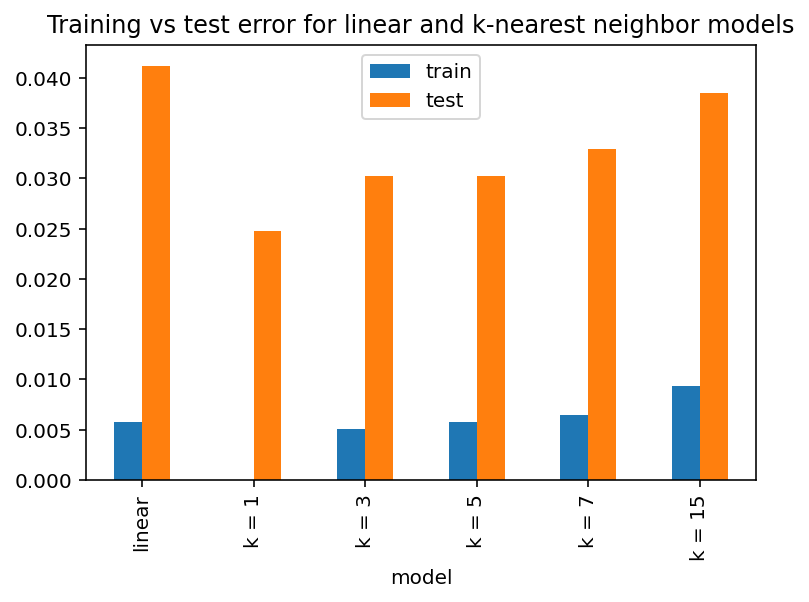

In [124]:
errors_df.plot.bar()
_ = plt.title('Training vs test error for linear and k-nearest neighbor models')

## 2. 7.5 
### For a linear  smoother $\hat{y} = S y$, show that 
### $\sum_{i=1}^N Cov(\hat{y_i}, y_i)  = trace(S) \sigma^2 $
### which justifies its use   as  the effective number of parameters.  



(Hastie, Section 7.3)

We  assume 		 	 	 		
$ Y = f(X)+ε$ where $E(ε) = 0$ and $Var(ε) = σ^2 $

i.e. $σ^2$ is irreducible error; $Cov(y_i, y_i) =  σ^2$

Consider S linear in y, the eigendecomposition of S. S scales   the components $y_i$ of $y$ by its eigenvalues.

$\sum_{i=1}^N Cov(y_i, y_i) = \sum_{i=1}^N  \sigma^2  = trace(I) \sigma^2 $

Now we have $\sum_{i=1}^N Cov(\hat{y_i}, y_i) = \sum_{i=1}^N S_{ii} \sigma^2  = trace(S) \sigma^2 $




## 3. 3.17 
### Repeat the analysis of Table 3.3 on the spam data discussed in Chapter 1.

In [214]:
spam = pd.read_csv('spam.txt', header=None, delimiter=" ")
print(len(spam))
# spam.head()

4601



##### About the data
https://web.stanford.edu/~hastie/ElemStatLearn/

The data for this example consists of information from 4601 email messages, in a study to try to predict whether the email was junk email, or “spam.”

48 continuous real [0,100] attributes of type word_freq_WORD 
= percentage of words in the e-mail that match WORD,
i.e. 100 * (number of times the WORD appears in the e-mail) / 
total number of words in e-mail.  A "word" in this case is any 
string of alphanumeric characters bounded by non-alphanumeric 
characters or end-of-string.

6 continuous real [0,100] attributes of type char_freq_CHAR
= percentage of characters in the e-mail that match CHAR,
i.e. 100 * (number of CHAR occurences) / total characters in e-mail

1 continuous real [1,...] attribute of type capital_run_length_average
= average length of uninterrupted sequences of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_longest
= length of longest uninterrupted sequence of capital letters

1 continuous integer [1,...] attribute of type capital_run_length_total
= sum of length of uninterrupted sequences of capital letters
= total number of capital letters in the e-mail

1 nominal {0,1} class attribute of type spam
= denotes whether the e-mail was considered spam (1) or not (0), 
i.e. unsolicited commercial e-mail.


In [ ]:
X = spam[list(range(57))]
y = spam[57]

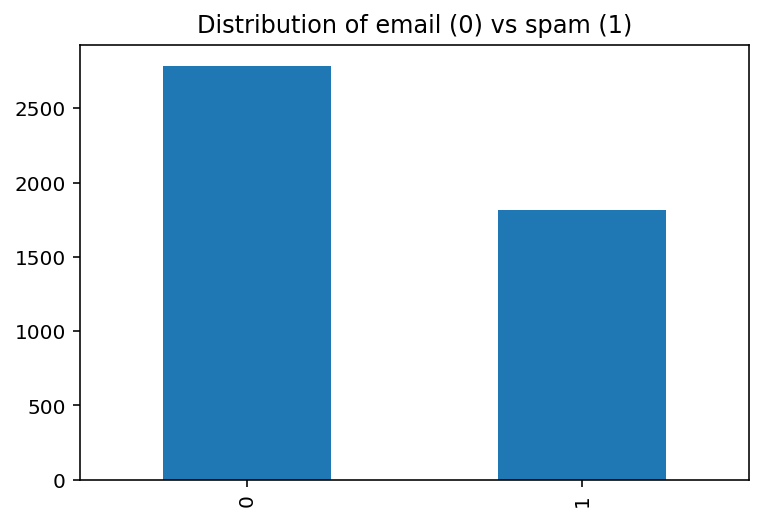

In [138]:
#  total distribution of spam vs not-spam
y.value_counts().plot.bar()
_ = plt.title('Distribution of email (0) vs spam (1)')

Since there are 57 predictors, the number of subsets becomes $2^{57} = 1.44 × 10^{17}$. This will be time-consuming even without cross-validation. We therefore do not use the best-subset method.

Also, unlike the data for the table in 3.3: This is a classification problem, so we compute the error as the misclassification error, using the indicator function, rather than RMSE.


As per
Hastie (7.49): Test error is estimated by averaging over the cross validation error.


In [391]:
results_df = pd.DataFrame(columns=['results', 'Least Squares', 'Ridge', 'Lasso']).set_index('results')

In [392]:
def cv_test_error(errors):
    """Assumes length of errors is the  same."""
    return np.mean(errors)

def cv_standard_error(errors):
    k = len(errors)
    test_error = np.mean(errors)
    return np.sqrt((sum((errors - test_error)**2))/(k-1))

In [393]:
from sklearn import linear_model, metrics
from sklearn.model_selection import cross_validate

OLS

In [394]:
# Make custom classification scorer for OLS cross validation

def _classification_score(y_true, y_pred):
    """
    Custom misclassification error function for OLS linear regression
    """
    misclassification_error = (np.abs(y_true - y_pred) > 0.5).sum()/len(y_true)
    return misclassification_error

classification_score = metrics.make_scorer(_classification_score)

assert(_classification_score(pd.Series([0,1]), pd.Series([0.1, 0.9]))==0)
assert(_classification_score(pd.Series([0,1]), pd.Series([0, 1]))==0)
assert(_classification_score(pd.Series([0,1]), pd.Series([1, 0]))==1)
assert(_classification_score(pd.Series([0,1]), pd.Series([1, 0.4]))==1)
assert(_classification_score(pd.Series([0,1]), pd.Series([1, 0.8]))==0.5)

In [395]:
# OLS
ls = linear_model.LinearRegression()
ls_cv_results = cross_validate(ls, X, y, cv=10, scoring=classification_score) # accuracy score

In [396]:
results_df.loc['test error', 'Least Squares'] = cv_test_error(ls_cv_results['test_score'])
results_df.loc['standard error', 'Least Squares'] = cv_standard_error(ls_cv_results['test_score'])
results_df

,Least Squares,Ridge,Lasso
results,,,
test error,0.164265,NaN,NaN
standard error,0.123552,NaN,NaN


Ridge and Lasso

They use regularization. This is parameterized in sklearn as an alpha value.

In [397]:
alphas_lin = np.linspace(0, 10, num=50)

In [398]:
# Ridge regression
ridge_results = [] # contains tuples: (test error - std, test error, test error + std) corresponding to alphas
min_err = 1
min_alpha = 0
for i, alpha in enumerate(alphas_lin):
    ridge_clf = linear_model.RidgeClassifier(alpha=alpha)
    results = cross_validate(ridge_clf, X, y, cv=10)
    ridge_test_error = cv_test_error(1 - results['test_score'])
    ridge_std = cv_standard_error(1 - results['test_score'])
    if ridge_test_error + ridge_std < min_err:
        min_err = ridge_test_error
        min_alpha = alpha
    ridge_results += [(ridge_test_error - ridge_std, ridge_test_error, ridge_test_error + ridge_std)]

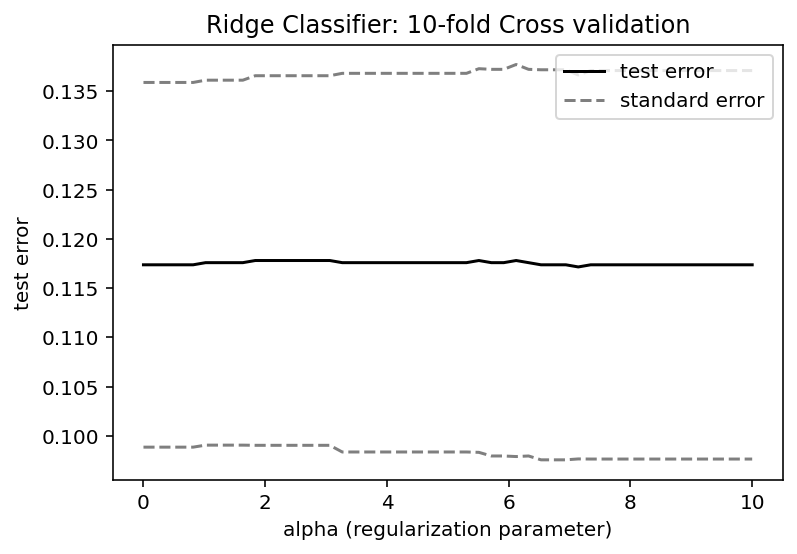

In [399]:
fig, ax = plt.subplots(1,1)
ax.plot(alphas_lin, [e for (_, e, _) in ridge_results], '-', color='black', label='test error')
ax.plot(alphas_lin, [s for (s, _e, _) in ridge_results], '--', color='black',alpha=0.5, label='standard error')
ax.plot(alphas_lin, [s for (_, _e, s) in ridge_results], '--', color='black',alpha=0.5)
ax.set_xlabel('alpha (regularization parameter)')
ax.set_ylabel('test error')
ax.legend()
ax.set_title('Ridge Classifier: 10-fold Cross validation')
plt.show()

The test errors do not change much and are all  within a standard error of the others. Take alpha=1 since  it's  the  default.

In [400]:
ridge_clf = linear_model.RidgeClassifier(alpha=1)
ridge_results = cross_validate(ridge_clf, X, y, cv=10)
results_df.loc['test error', 'Ridge'] = cv_test_error(1 - ridge_results['test_score'])
results_df.loc['standard error', 'Ridge'] = cv_standard_error(1 - ridge_results['test_score'])

Lasso

For the python sklearn based  implementation, we use LogisticRegression with the l1 penalty.

We'll use the same (default) regularization parameter as the Ridge classifier.

In [401]:
l1_clf = linear_model.LogisticRegression(penalty='l1',solver='liblinear')
l1_results = cross_validate(l1_clf, X, y, cv=10)
results_df.loc['test error', 'Lasso'] = cv_test_error(1 - l1_results['test_score'])
results_df.loc['standard error', 'Lasso'] = cv_standard_error(1 - l1_results['test_score'])
results_df

,Least Squares,Ridge,Lasso
results,,,
test error,0.164265,0.117581,0.081724
standard error,0.123552,0.018531,0.035002


PCR and  PLS

I worked on this for a  while with issue after issue...

sklearn does not have an implementation of PCA out-of-the-box. Rolling my own proved too difficult since the scoring parameter does not accept my custom scoring  function. i.e. it would take a bit too many hours to  transform these functions to be classifiers.

See a  saved experiment below.
So skipping this...

In [402]:
from sklearn.cross_decomposition import PLSRegression
clf = PLSRegression(n_components=25).fit(X,y)
cross_validate(clf, X, y.ravel(), cv=10, scoring=classification_score)

{'fit_time': array([0.05886602, 0.05559993, 0.05418611, 0.0541048 , 0.05624008,
        0.05752707, 0.05444098, 0.05920291, 0.0757041 , 0.08799314]),
 'score_time': array([0.00499105, 0.00437403, 0.0050807 , 0.00442314, 0.00436401,
        0.00476384, 0.0044508 , 0.00455594, 0.00648975, 0.006706  ]),
 'test_score': array([175.        , 128.        , 106.        , 176.15652174,
         20.        ,  31.        ,  36.        ,  32.        ,
         27.        ,  59.        ])}

## 4. 3.30
### Consider the elastic-net optimization problem  and show how one can turn this into a lasso problem, using an augmented version of X and y. 


Suppose X is a N x p matrix: There are p  coefficients and N samples.

y is a N  x  1 matrix.

The elastic  net optimization problem can be written as

$$ \underset{\beta}{min} \{ \sum_{i=1}^N (y_i  - \sum_{j=1}^p x_{i,j}\beta_j)^2  + \lambda  \sum_{j=1}^p (\alpha \beta_j^2  + (1 - \alpha)|\beta_j|) \} $$

And the lasso problem  can be  written  as
$$ \underset{\beta}{min} \{ \sum_{i=1}^N (y_i  - \sum_{j=1}^p x_{i,j}\beta_j)^2  + \lambda  \sum_{j=1}^p |\beta_j| \}$$


Consider augmenting  X and y so that  the N  x  p  matrix
$\begin{bmatrix}
X
\end{bmatrix}$ 
becomes the (N + p) x p matrix 
$\begin{bmatrix}
X \\
\gamma I
\end{bmatrix}$

and the N  x  1 column vector $\begin{bmatrix}
y
\end{bmatrix}$
becomes the (N + p) x 1 vector $\begin{bmatrix}
y \\
0
\end{bmatrix}$ equivalent to y padded with p zeros.

Note  that the number of $\beta$ parameters in the problem does not change.

With the augmented X and y we can rewrite the elastic net problem as

$
    \underset{\beta}{min} \{ \sum_{i=1}^N (y_i  - \sum_{j=1}^p x_{i,j}\beta_j)^2  + \sum_{i=N+1}^{N+p} (y_i  - \sum_{j=1}^p x_{i,j}\beta_j)^2  + \lambda  \sum_{j=1}^p (\alpha \beta_j^2  + (1 - \alpha)|\beta_j|) \} 
    $
    


For $N + 1 \leq i \leq N + p$, 

$x_{i,j} = 0$ when $ N+i \neq j$ and $\gamma$ otherwise

So then $\sum_{i=N+1}^{N+p} (y_i  - \sum_{j=1}^p x_{i,j}\beta_j)^2 = \sum_{i=N+1}^{N+p} (0_i  - \gamma \beta_j)^2 $ where $j = i - N$

So this term is  equivalent  to 

$\sum_{j=1}^p(\gamma \beta_j)^2 = \gamma^2 \sum_{j=1}^p \beta_j^2 $


And we have

$
\underset{\beta}{min} \{ \sum_{i=1}^N (y_i  - \sum_{j=1}^p x_{i,j}\beta_j)^2 + \gamma^2 \sum_{j=1}^p \beta_j^2 +\lambda  \sum_{j=1}^p (\alpha \beta_j^2  + (1 - \alpha)|\beta_j|) \} 
    $
    
    
We can also expand the last term to have

$
\underset{\beta}{min} \{ \sum_{i=1}^N (y_i  - \sum_{j=1}^p x_{i,j}\beta_j)^2 + \gamma^2 \sum_{j=1}^p \beta_j^2 + \lambda \alpha  \sum_{j=1}^p \beta_j^2  + \lambda(1 - \alpha)\sum_{j=1}^p |\beta_j|) \}
    $

If we choose $\gamma, \lambda, \alpha$ s.t. $\gamma^2 = -\lambda \alpha$, or,  $\gamma = i\sqrt{\lambda \alpha} $ then this is the lasso problem.